Text(0, 0.5, 'measure vals')

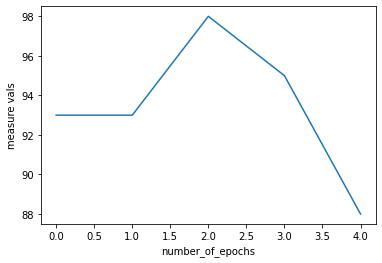

In [25]:
# Backprop on the Seeds Dataset
from random import seed
from math import exp
import matplotlib.pyplot as plt
from random import randrange
from random import random
import numpy as np
from csv import reader


 
# how to Load a CSV file with a sample dataset(seeds Data Set)
def load_csv_func(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for i in csv_reader:
			if not i:
				continue
			dataset.append(i)
	return dataset
 
# next we are Converting the string column to float value
def convert_string_column_to_float(dataset, column):
	for i in dataset:
		i[column] = float(i[column].strip())
 
#then we Convert string column to integer value
def convert_string_column_to_integer(dataset, k):
	class_values = [i[k] for i in dataset]
	unique = set(class_values)
	vp = dict()
	for i, value in enumerate(unique):
		vp[value] = i
	for j in dataset:
		j[k] = vp[j[k]]
	return vp
 
#function to identify the maximum and minimum values within  each column
def dataset_minmax_func(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats
 
# changing the dataset range within 0-1
def normalizing_dataset_func(dataset, minmax):
	for j in dataset:
		for i in range(len(j)-1):
			j[i] = (j[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
 
# using k fold function to split our dataset
def func_for_cross_validation_split(dataset, number_of_folds):
	value = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / number_of_folds)
	for i in range(number_of_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		value.append(fold)
	return value
 
# finding the accuracy %
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
# function for evaluating the algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = func_for_cross_validation_split(dataset, n_folds)
	vals = list()
	for i in folds:
		train_set = list(folds)
		train_set.remove(i)
		train_set = sum(train_set, [])
		test_set = list()
		for row in i:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in i]
		accuracy = accuracy_metric(actual, predicted)
		vals.append(accuracy)
	return vals
 
# function for finding neuron activation within any given input
def activate(weights, inputs):
	activation_val = weights[-1]
	for i in range(len(weights)-1):
		activation_val += weights[i] * inputs[i]
	return activation_val
 
# function for neuron activation transfer
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))
 
# function to forward propagate the given input into network output
def forward_propagate_func(network, row):
	input_val = row
	for i in network:
		new_inputs = []
		for j in i:
			activation = activate(j['weights'], input_val)
			j['output'] = transfer(activation)
			new_inputs.append(j['output'])
		input_val = new_inputs
	return input_val
 
# finding  the derivative of an neuron output
def transfer_derivative_func(output):
	return output * (1.0 - output)
 
# Backpropagate error function
def backward_propagate_error_func(network, expected):
	for i in reversed(range(len(network))):
		each_layer_val = network[i]
		error_val = list()
		if i != len(network)-1:
			for j in range(len(each_layer_val)):
				error = 0.0
				for k in network[i + 1]:
					error += (k['weights'][j] * k['delta'])
				error_val.append(error)
		else:
			for j in range(len(each_layer_val)):
				k = each_layer_val[j]
				error_val.append(k['output'] - expected[j])
		for j in range(len(each_layer_val)):
			k = each_layer_val[j]
			k['delta'] = error_val[j] * transfer_derivative_func(k['output'])
 
# function for updating network weights with error
def update_weights_func(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] -= l_rate * neuron['delta']
 
# next we train a network for a certain number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate_func(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			backward_propagate_error_func(network, expected)
			update_weights_func(network, row, l_rate)
 
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network
 
# predicting  with a network
def predict(network, row):
	outputs = forward_propagate_func(network, row)
	return outputs.index(max(outputs))
 
#  function for backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)
 
seed(1)
filename = '/content/drive/MyDrive/wheat-seeds.csv'
dataset = load_csv_func(filename)
for i in range(len(dataset[0])-1):
	convert_string_column_to_float(dataset, i)
convert_string_column_to_integer(dataset, len(dataset[0])-1)
minmax = dataset_minmax_func(dataset)
normalizing_dataset_func(dataset, minmax)
n_folds = 5
l_rate = 0.3
n_epoch = 500
n_hidden = 5 #this value can be changed to represent both deep and shalow models and plot the visualization
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
measure=list(np.round(scores,0))
measure
epochs=[0,1,2,3,4]
plt.plot(epochs,measure)
plt.xlabel('number_of_epochs')
plt.ylabel('measure vals')